# Kinematics, Dynamics, Visualization + Control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from functools import partial

from IPython.display import clear_output
from costs import *
from ocp_sys import *

from scipy.optimize import fmin
import crocoddyl
import os
import casadi
from casadi import mtimes, MX, sin, cos, vertcat, horzcat, sum1, cross, Function, jacobian, solve

np.set_printoptions(precision=4, suppress=True)
%load_ext autoreload
%autoreload 2

## Part 1: Standard Controller 

#### Try solving and analyse result

In [2]:
biped = Biped_Casadi()
biped.def_compute_matrices()

COT: 2060.90, Dist: 0.327, dT: 0.376


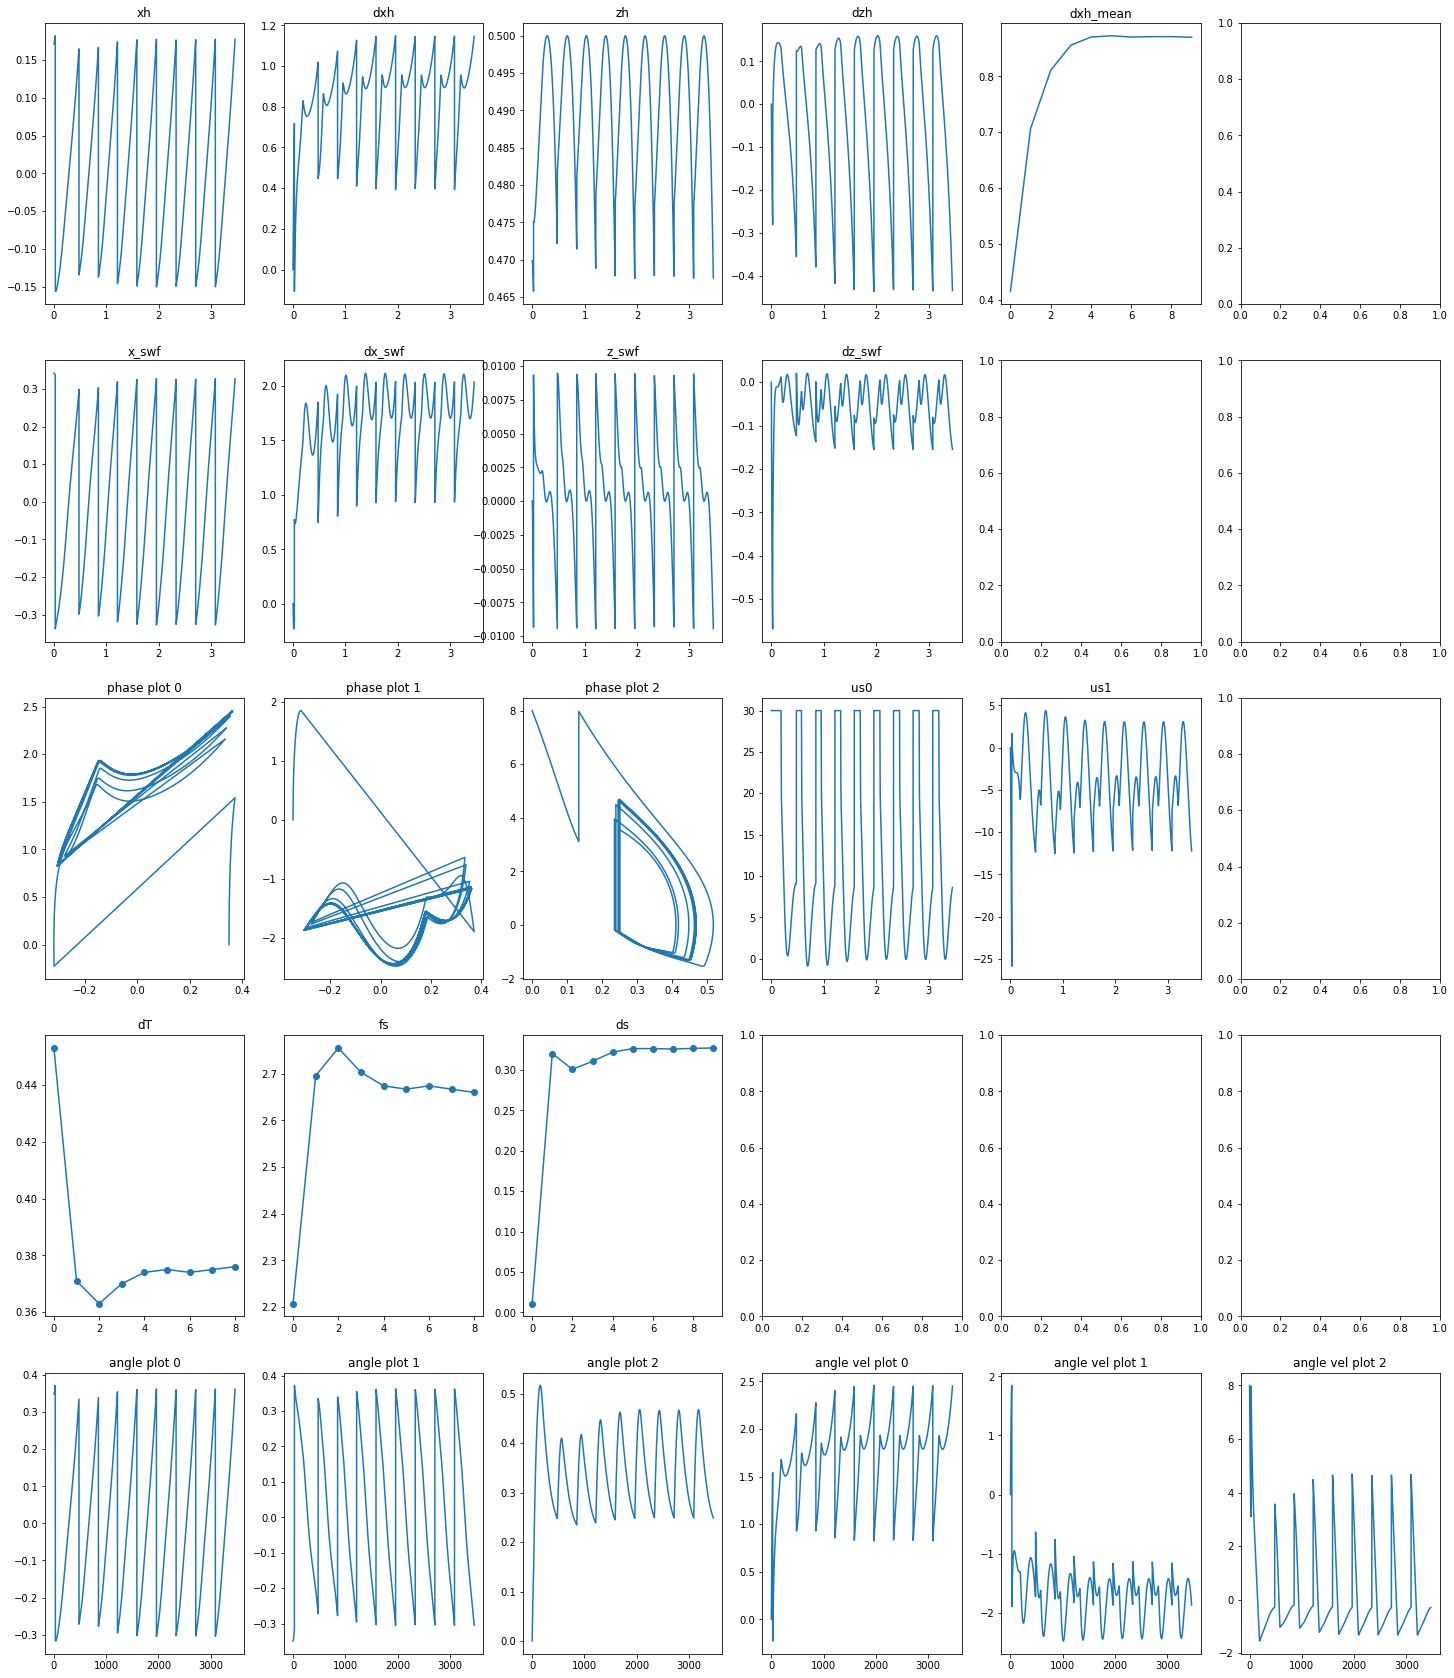

In [3]:
#standard values with standard params
q0 = np.array([np.pi/9, -np.pi/9, 0.])
dq0 = np.array([0.,0.,8.])

sln = biped.solve_eqns(q0, dq0, 10, biped.control_parameters)

%matplotlib inline
res = biped.analyse(sln, biped.control_parameters, to_plot=True)

#### Optimize the standard controller

In [4]:
def opt_func(opt_parameters, num_steps):
    print(num_steps)
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    control_params = opt_parameters[6:]

    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, control_params);
    results = biped.analyse(sln, control_params, False)

    # calculate metrics 
    distance = np.sum(results['ds'])
    frequency = (results['fs'][-1])
    last_velocity = results['last_mean_velocity']
    ave_velocity = results['total_mean_velocity']
    CoT = results['cot']
    step_length = (results['ds'])[-1]

    w1, w2, vd, sd = 10, 1e-3, .8, 0.4 
    
    velocity = last_velocity
    objective_value = w1*abs(vd - velocity) + w2*CoT 
    #objective_value = w1*abs(sd - step_length) + w2*CoT

    if distance < 0 or CoT < 0 or velocity < 0:
        objective_value = 1000        

    print('Obj:{}, vel:{}, step length:{}:'.format(objective_value, velocity, step_length))
    print('Params', opt_parameters)
    return objective_value

In [5]:
#optimize
biped.set_control()
opt_parameters0 = np.concatenate([q0, dq0, biped.control_parameters])

In [ ]:
res = fmin(opt_func, opt_parameters0, args = (10,), disp=1, full_output=True, maxiter = 100)
opt_params = res[0]

#opt_params = np.array([-0.284113, 0.345539, 0.048467, 0.788421, -0.485341, 2.686219, 476.012732, 156.719241, 77.309297, 6.410483, 0.041308])

#### Observe the result

In [ ]:
#extract the optimization result
q0, dq0, params = opt_params[:3], opt_params[3:6], opt_params[6:]

#run simulation using the optimized parameters
biped.set_control()
sln = biped.solve_eqns(q0, dq0, 10, params);

%matplotlib inline
ress = biped.analyse(sln, params, True)

#### Collect the resulting initial and final configs (to obtain the steady state part)

COT: 1798.24, Dist: 0.326, dT: 0.375


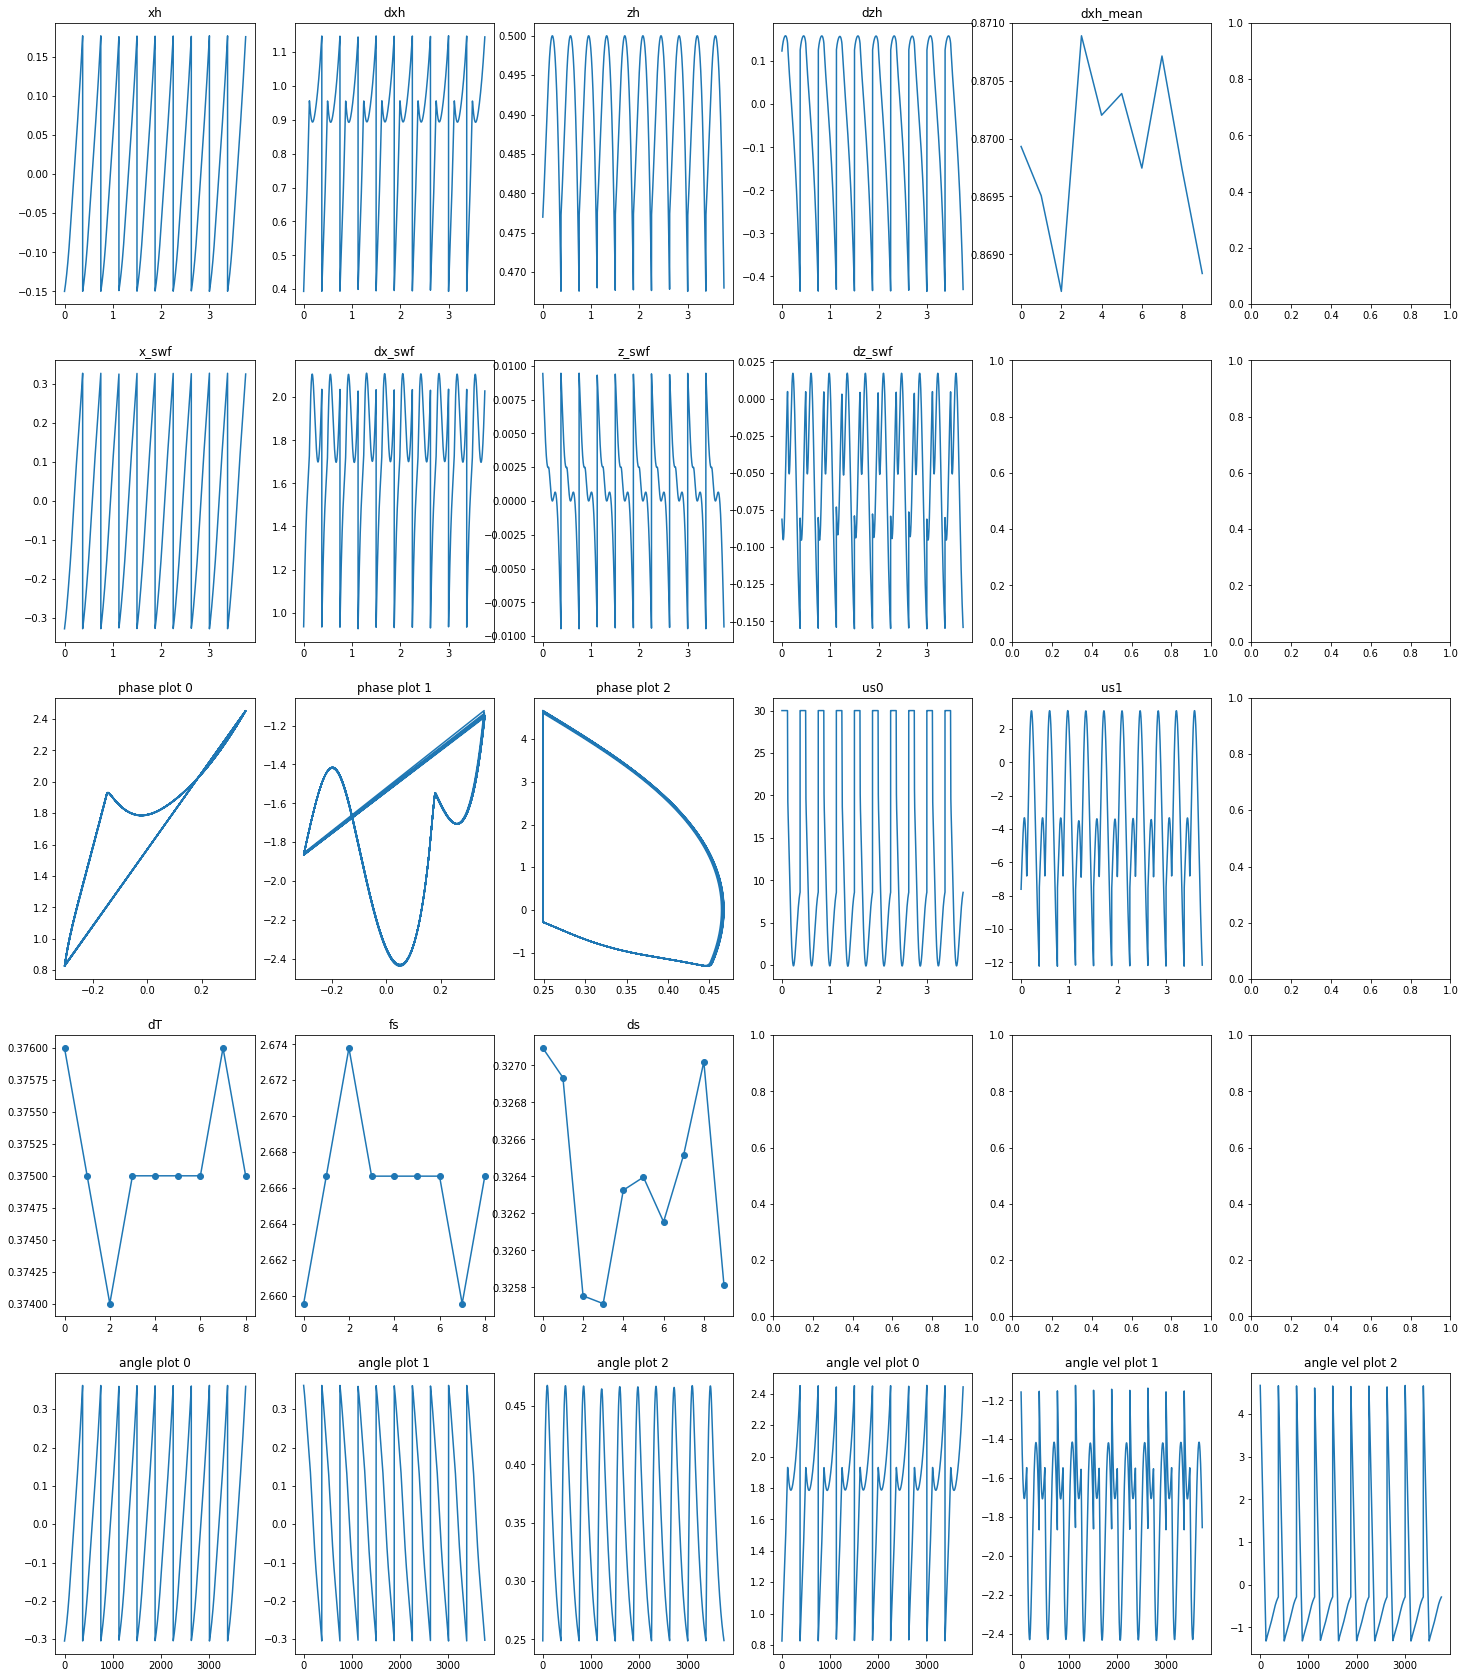

In [9]:
from utils import extract_init_goal

y0, yT = extract_init_goal(sln)
q0, dq0 = y0[-1,:3], y0[-1,3:]
qT, dqT = yT[-1,:3], yT[-1,3:]
T = sln['T'][-1][-1] - sln['T'][-1][0]
T = int(T/biped.dT)

biped.set_control()
sln = biped.solve_eqns(q0, dq0, 10, params)
clear_output()

res = biped.analyse(sln, params, to_plot=True)

## Part 2: Using iLQR

### Formulate the iLQR problem

In [84]:
print(q0)
x0 = np.concatenate([q0, dq0])
xT = np.concatenate([qT, dqT])

Tc = T #375
x_ref = xT.copy()
biped.set_init_state(x0)

[-0.2842  0.3455  0.0485]


#### Define cost

In [85]:
u_max = 30
step_length = res['x_swf'][-1]

#standard cost on state and control
Q = np.diag([0,0,100,0,0,0])
Qf = np.diag([0,0,100,0,0,0])
R = np.eye(biped.Du)*.01

#swing trajectory
Wt = np.diag([0, 1e4])
z_refs = np.linspace(0.005, -0.01, Tc)

#swing foot final position
WT = np.diag([1e4, 1e5])*1
p_ref = np.array([step_length, -0.01])

costs = []
for i in range(Tc):
    if i < Tc/12:
        runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
    else:
        runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)
        
    runningControlCostShort = CostModelQuadratic(biped, None, R)
    p_ref_t = np.array([0, z_refs[i]])
    
    if i > Tc/12:
        runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
    else:
        runningEECost = CostModelQuadraticTranslation(biped, .1*Wt, p_ref = p_ref_t)
        
    runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
    costs += [runningCostShort]
    
terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
terminalControlCost = CostModelQuadratic(biped, None,R)
terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
costs += [terminalCost]

#for crocoddyl
#### Setup crocoddyl model
rmodels = []
for i in range(Tc):
    state = crocoddyl.StateVector(biped.Dx)
    rmodel = ActionModelRobot(state, biped.Du)
    rmodel.init_robot_sys(biped, nr = biped.Dx)
    rmodel.set_cost(costs[i])
    rmodel.u_lb = np.array([-u_max, -u_max])
    rmodel.u_ub = np.array([u_max,u_max])
    rmodels += [rmodel]

rmodel_T = ActionModelRobot(state, biped.Du)
rmodel_T.init_robot_sys(biped, nr = biped.Dx)
rmodel_T.set_cost(terminalCost)
rmodel_T.u_lb = np.array([-u_max, -u_max])
rmodel_T.u_ub = np.array([u_max,u_max])

problem = crocoddyl.ShootingProblem(x0, rmodels, rmodel_T)

#### Initialization

In [86]:
xs_init = np.array([x0]*(Tc+1))
us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((Tc+1, 3))))
biped.set_init_state(x0)

#### Solve

In [87]:
ddp = crocoddyl.SolverBoxFDDP(problem)

ddp.th_grad = 1e-6
ddp.th_stop = 1e-6
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

ddp.solve(list(xs_init[:,:,None]), list(us_init[:-1,:,None]), maxiter=10)

xs_ref, us_ref = np.array(ddp.xs), np.array(ddp.us)
effort_ilqr = np.sum(us_ref[:,0]**2 + us_ref[:,1]**2)/(2*T*biped.dT*30)

%matplotlib qt
z_swfs = biped.animate_ys(xs_ref)

#### Try simulation with ilqr

In [88]:
biped.set_control('ilqr', ddp)

In [89]:
sln = biped.solve_eqns(q0, dq0,10, biped.control_parameters)
clear_output()

In [ ]:
%matplotlib inline
res = biped.analyse(sln, biped.control_parameters, True)

### Optimizing ILQR

In [91]:
def opt_func_ilqr(opt_parameters, num_steps):
    # extract parameters q0, dq0 and x
    q0 = opt_parameters[:3]
    dq0 = opt_parameters[3:6]
    y0 = np.concatenate([q0, dq0])
    #Tc = opt_parameters[6]
    alpha = opt_parameters[6]
    step_length = opt_parameters[7]

    
    #define ilqr
    x_ref = np.array([0,0,alpha,0,0,0])
    biped.set_init_state(y0.copy())

    u_max = 30

    Q = np.diag([0,0,100,0,0,0])
    Qf = np.diag([0,0,100,0,0,0])
    R = np.eye(biped.Du)*.01

    #swing trajectory
    Wt = np.diag([0, 1e4])
    z_refs = np.linspace(0.005, -0.005, Tc)

    #swing foot final position
    WT = np.diag([1e4, 1e5])*1
    p_ref = np.array([step_length, -0.01])

    costs = []
    for i in range(Tc):
        if i < Tc/12:
            runningStateCostShort = CostModelQuadratic(biped, 0.01*Q, x_ref = x_ref)
        else:
            runningStateCostShort = CostModelQuadratic(biped, Q, x_ref = x_ref)

        runningControlCostShort = CostModelQuadratic(biped, None, R)
        p_ref_t = np.array([0, z_refs[i]])

        if i > Tc/12:
            runningEECost = CostModelQuadraticTranslation(biped, Wt, p_ref = p_ref_t)
        else:
            runningEECost = CostModelQuadraticTranslation(biped, .1*Wt, p_ref = p_ref_t)

        runningCostShort = CostModelSum(biped, [runningStateCostShort, runningControlCostShort, runningEECost])    
        costs += [runningCostShort]

    terminalStateCost = CostModelQuadratic(biped,Qf, x_ref = x_ref)
    terminalControlCost = CostModelQuadratic(biped, None,R)
    # terminalEEVelCost = CostModelQuadraticLinVel(biped, Wv, p_ref = v_ref)
    terminalEECost = CostModelQuadraticTranslation(biped, WT, p_ref = p_ref)
    terminalCost = CostModelSum(biped, [terminalStateCost, terminalControlCost,terminalEECost ])
    costs += [terminalCost]

    #for crocoddyl
    #### Setup crocoddyl model
    rmodels = []
    for i in range(Tc):
        state = crocoddyl.StateVector(biped.Dx)
        rmodel = ActionModelRobot(state, biped.Du)
        rmodel.init_robot_sys(biped, nr = biped.Dx)
        rmodel.set_cost(costs[i])
        rmodel.u_lb = np.array([-u_max, -u_max])
        rmodel.u_ub = np.array([u_max,u_max])
        rmodels += [rmodel]

    rmodel_T = ActionModelRobot(state, biped.Du)
    rmodel_T.init_robot_sys(biped, nr = biped.Dx)
    rmodel_T.set_cost(terminalCost)
    rmodel_T.u_lb = np.array([-u_max, -u_max])
    rmodel_T.u_ub = np.array([u_max,u_max])

    problem = crocoddyl.ShootingProblem(y0, rmodels, rmodel_T)
    ddp = crocoddyl.SolverBoxFDDP(problem)

    ddp.th_grad = 1e-6
    ddp.th_stop = 1e-6
    ddp.setCallbacks([crocoddyl.CallbackVerbose()])
    
    
    #train ilqr
    xs_init = np.array([y0]*(ddp.problem.T+1))
    us_init = np.array(biped.compute_inverse_dynamics(xs_init, np.zeros((ddp.problem.T+1, 3))))
     
    ddp.solve(list(xs_init[:,:,None]), list(us_init[:-1,:,None]), maxiter=10)
    
        

    biped.set_control('ilqr', ddp)

    
    # run simulation
    sln = biped.solve_eqns(q0, dq0, num_steps, None);
    results = biped.analyse(sln, biped.control_parameters, False)

    # calculate metrics such as distance, mean velocity and cost of transport
    max_actuation = 30;
    effort = results['effort']
    distance = np.sum(results['ds'])
    velocity = results['total_mean_velocity']
    CoT = results['cot']
    print('cot:{}'.format(CoT))
    
    y0T = sln['Y'][-1][0]
    qT = results['qs'][-1]
    dqT = results['dqs'][-1]
    
    q0n, dq0n = biped.impact(qT, dqT)
    yn = np.concatenate([q0n, dq0n])
    
    objective_value = np.linalg.norm(yn-y0T)
    w1 = 10
    w2 = 0.001
    vd = 0.9
    
    step_length = (results['ds'])[-1]
    s_d = 0.4
    #objective_value = w1*abs(vd - velocity) + w2*CoT #- 0.3*distance
    #objective_value = w1*abs(s_d - step_length) + w2*CoT #- 0.3*distance
    
    #objective_value = w1*abs(velocity-vd) + w2*CoT
    #objective_value = -np.mean(results['ds'][-3:])
    print('Obj:{0:.3f}, vel:{1:.3f}, step length:{2:.3f}:'.format(objective_value, velocity, step_length))
    print('Params:', opt_parameters)
    print('y0T, yn', y0T, yn)
    return objective_value

In [93]:
opt_parameters0 = np.concatenate([q0, dq0, np.array([x_ref[2], step_length])])

#opt_parameters0 = opt_params.copy()

num_length = 1
res = fmin(opt_func_ilqr, opt_parameters0, args = (num_length,), disp=1, full_output=True, maxiter = 30)
clear_output()
print(res[1])
print(res[0])

#### Simulation using Optimized parameters

In [97]:
opt_params = res[0]

In [ ]:
#retrain ilqr using the optimal parameters
opt_func_ilqr(opt_params, 1)

### Define Noise

In [98]:
def clamp_noise(noise, sigma):
    for i in range(len(noise)):
        if noise[i] < -3*sigma:
            noise[i] = -3*sigma
        if noise[i] > 3*sigma:
            noise[i] = 3*sigma
    return noise

#### Set internal noise

#### Set external noise

### Simulate

In [104]:
#opt_params = res[0]
q0 = opt_params[:3]
dq0 = opt_params[3:6]
params = opt_params[6:]
params = biped.control_parameters
#opt_func_ilqr(opt_params)
sln = biped.solve_eqns(q0, dq0, 20, params)
%matplotlib qt
clear_output()
#biped.animate(sln)

COT: 199.09, Dist: 0.296, dT: 0.574


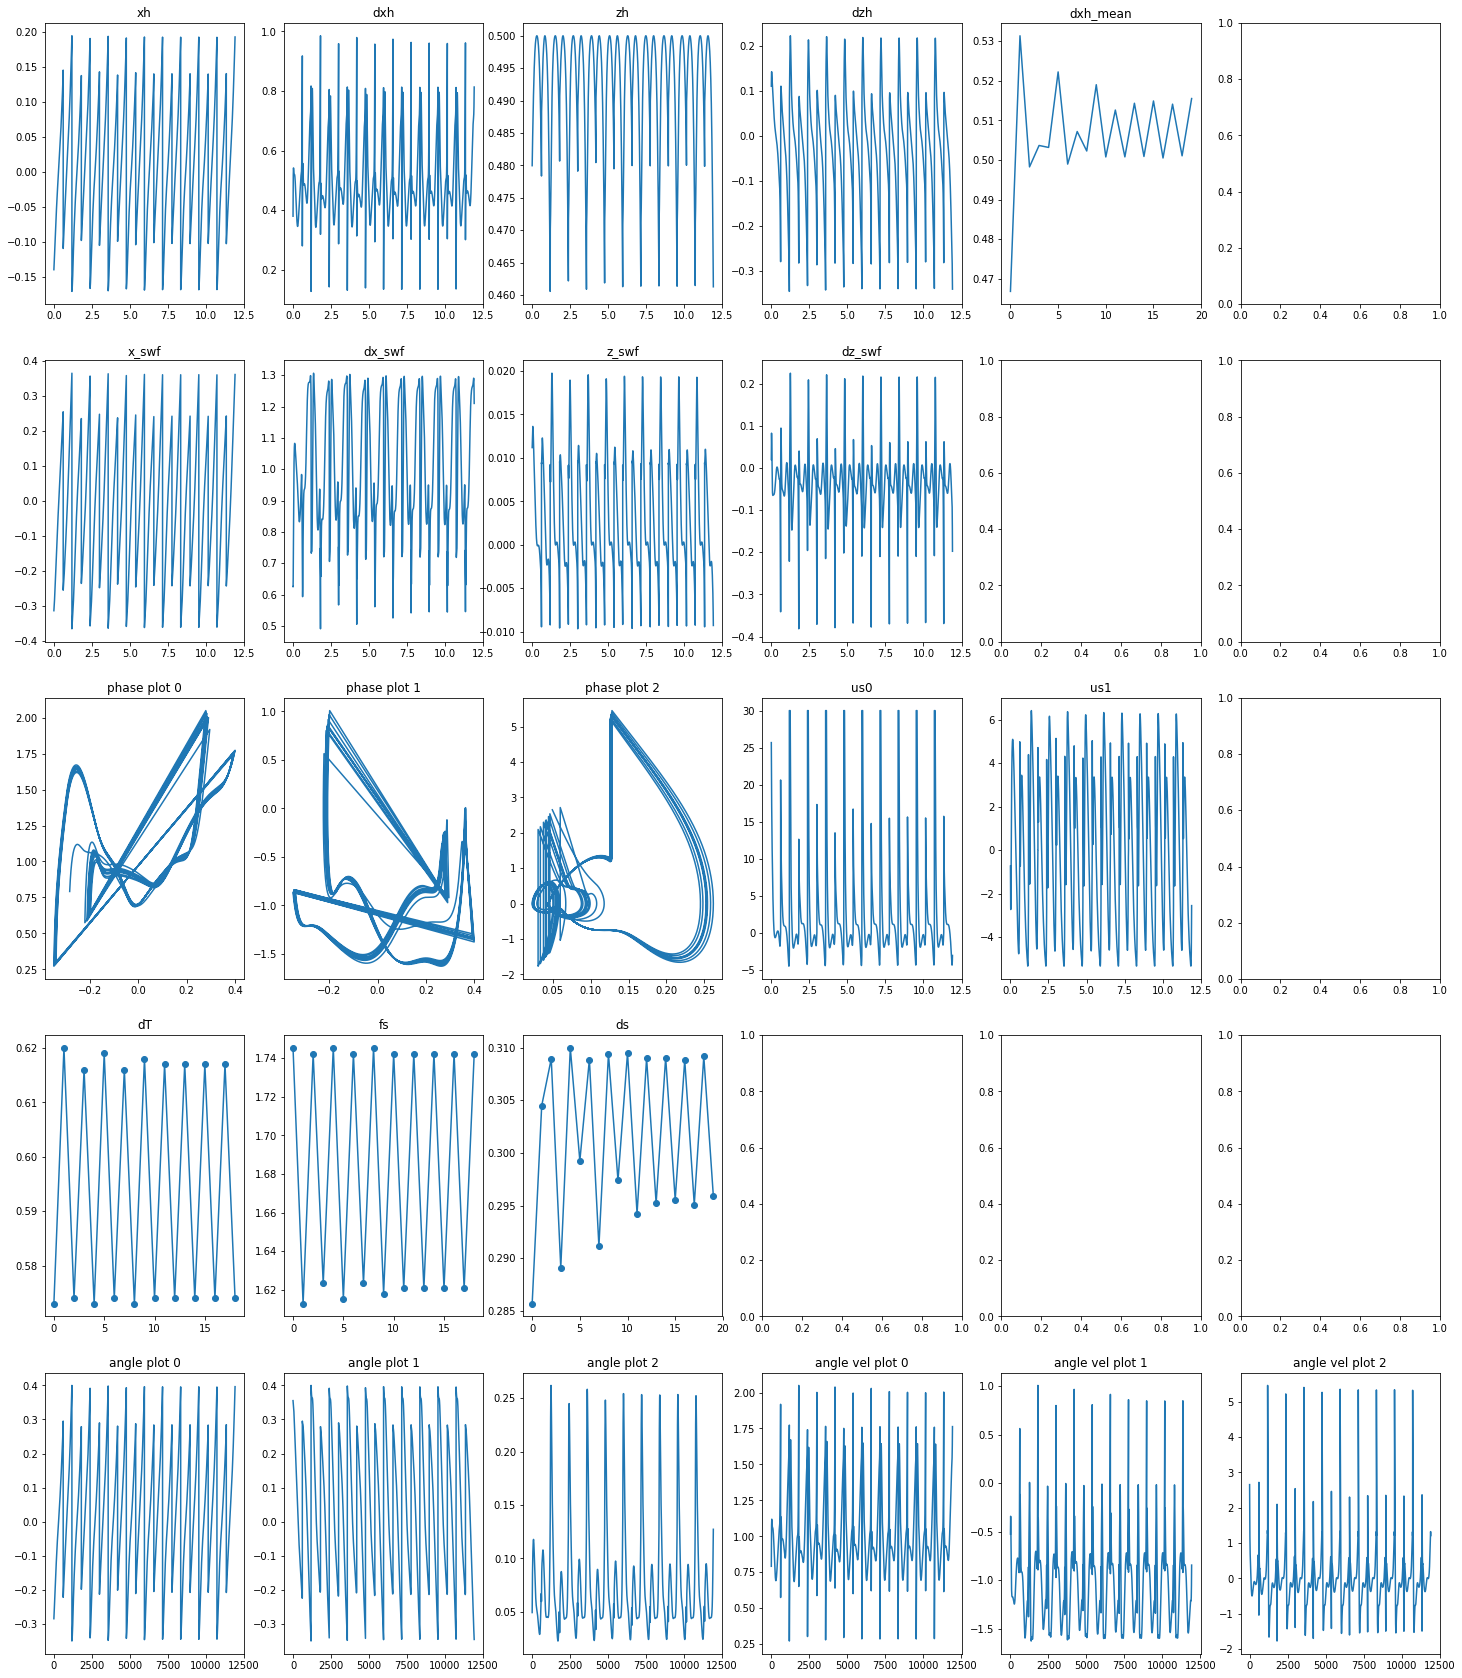

In [109]:
%matplotlib inline
result = biped.analyse(sln,params, to_plot = True)
plt.savefig('figures/example_f17_asymm.png')

#### Record Videos

In [106]:
%matplotlib qt
biped.animate(sln, skip = 25, to_save = True)

Real time factor:0.127091566667


0.12709156666723687

In [111]:
filename = 'asymmetric'
os.system('ffmpeg -r 10 -start_number 0 -i temp/walk%d.png -c:v libx264 -r 30 -pix_fmt yuv420p ' + 'temp/' + filename + '.mp4')
os.system('rm temp/*.png')

#### Save Data